# Utilizing Risk Factor Scores in Audit Data to Distinguish ‘Risky’ and ‘Not Risky’ Businesses

## 1. Introduction

Auditing is the process of investigating the financial records of businesses to ensure that they comply with internationally-accepted legal standards. In this project, the dataset used is the 'Audit Data' collected by the Comptroller and Auditor General (CAG) in India between 2015-2016. This data focuses on 777 firms from 46 cities that were grouped into 14 different sectors. The CAG investigated risk factors relevant to assisting auditors in accurately identifying businesses that pose a risk of committing unfair practices (N. Hooda et al., 2018). Our project revolves around applying predictive analytics using K-Nearest Neighbor (KNN) Classification to identify fraudulent firms in the case study above. Therefore, we will attempt to tackle the research question: Is a business risky of committing fraud based on its relevant risk factors?

All the variables in the dataset are ultimately used to calculate the Audit Risk Score (ARS). These variables account for the discrepancies that may occur during company transactions (Inherent risk), internal audit (Control risk), and external audit (Detection risk). The product of the Inherent, Control and Detection risk gives us the ARS. In the risk assessment, the companies with ARS scores greater or equal to 1 are identified as ‘risky’ firms and are assigned a risk assessment value of 1, whereas companies scoring less than 1 are classified as ‘not risky’ firms, getting a risk assessment score of 0.

Potential limitations include manipulation/incorrect logging of companies’ transactions at the internal audit stage to obtain lower control risk scores, and exclusion of other possible relevant factors that can influence the prediction.

## 2. Methods and Results

In [1]:
#load packages
options(repr.matrix.max.rows=6)
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(dplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Read dataset and correct variable types
audit_data <- read_csv("data/audit_risk.csv") |>
    mutate(Risk = as.factor(Risk)) |>
    mutate(LOCATION_ID = as.integer(LOCATION_ID)) 

#Splitting data into training set and testing set
set.seed(265)
audit_split <- initial_split(audit_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

#Printing training data set
audit_training

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2,2.156,0.4,0.5,0.4312,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,2,1.06,0.4,0.424,0.63,0.2,0.126,1.69,5,⋯,1.2,0,0.2,0,2.6,2.930,1.2,0.5,1.7580,1
55.57,32,0.00,0.2,0.000,8.49,0.6,5.094,8.49,5,⋯,0.4,0,0.2,0,3.2,6.580,0.4,0.5,1.3160,1
55.57,13,1.06,0.4,0.424,1.60,0.4,0.640,2.66,5,⋯,0.4,0,0.2,0,3.2,12.118,0.4,0.5,2.4236,1


### Summary of Dataset

In [3]:
#Table reporting number of sectors and number of firms under each sector
firm_count <- audit_training |>
    select(LOCATION_ID) |>
group_by(LOCATION_ID) |>
    summarise(firm_count = n())
    print('Table 1:Firm Count')
print(firm_count)

[1] "Table 1:Firm Count"
# A tibble: 42 × 2
   LOCATION_ID firm_count
         <int>      <int>
 1           1          9
 2           2         33
 3           3          3
 4           4         27
 5           5         35
 6           6         27
 7           7          4
 8           8         58
 9           9         42
10          11         18
# … with 32 more rows


The number of firms under each sector is counted using sector-unique historical risk scores (Sector_Score). The table shows 13 different sectors and the brief count of firms under each of them. Nonetheless, using Sector_Score may not produce the most accurate count as some sectors could have equal historical risk scores.

In [4]:
#Creating summary table of relevant variables
average_risk_factors <- audit_training |> 
    select(Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk) |> 
    map_dfc(mean, na.rm = TRUE)
    print('Table 2: Summary Table')
average_risk_factors

[1] "Table 2: Summary Table"


Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk
<dbl>,<dbl>,<dbl>,<dbl>
17.66497,0.5772806,0.5,6.275287


The average Audit Risk Score is 6.27, which is more than the benchmark 1 (according to the clear depiction in the plots below). This summary table alone could signify that most of the nominated businesses will likely be classified as risky. However, we have to remember that the average value could be skewed by extreme outliers.

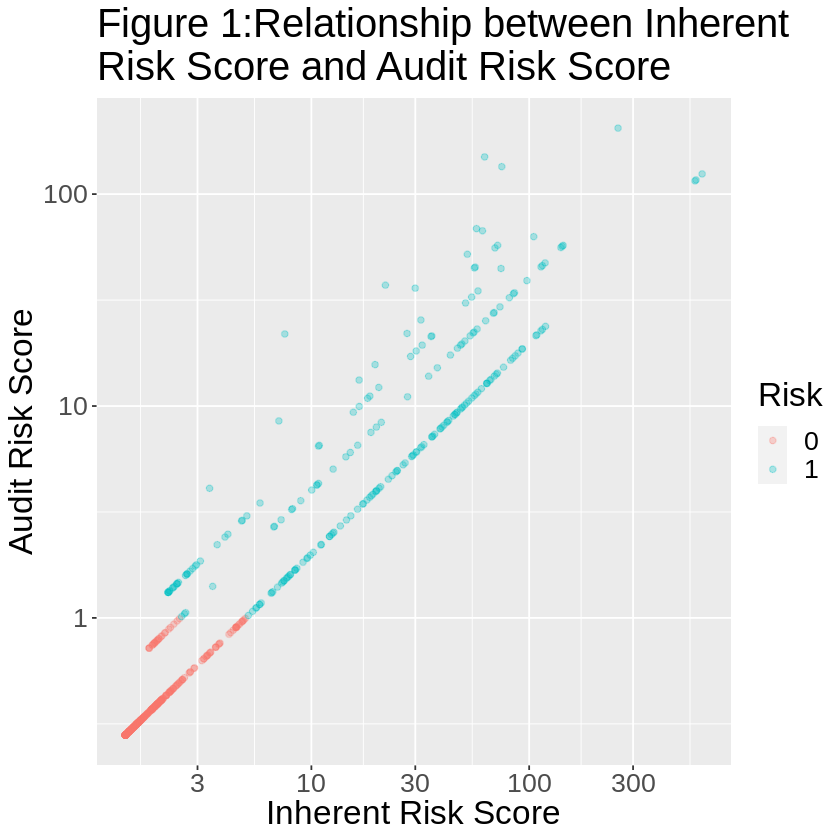

In [5]:
#Setting up plot size
options(repr.plot.width = 7, repr.plot.height = 7)

IR_AR_plot <- audit_training |>
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Inherent Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Figure 1:Relationship between Inherent \nRisk Score and Audit Risk Score') +
    theme(text = element_text(size =20))
IR_AR_plot

We see a strong positive linear relationship between Audit Risk Score and Inherent Risk Score. It also seems that the 'not risky' companies are clustered below an Audit Risk score of 1 whereas the ‘risky’ firms are spread out above an Audit Risk score of 1.

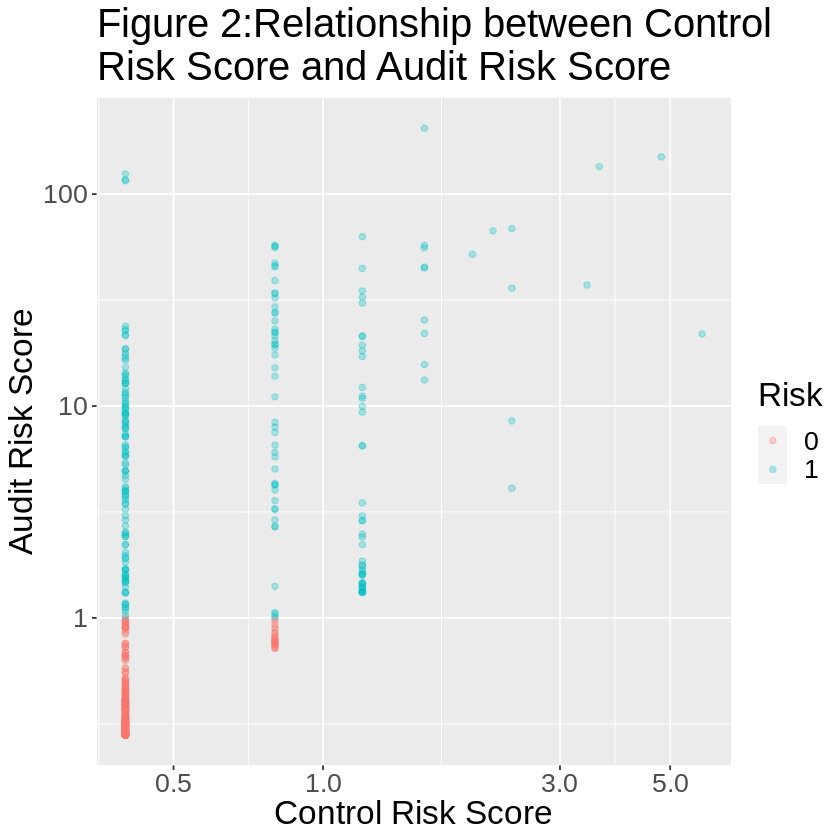

In [6]:
CR_AR_plot <- audit_training |>
    ggplot(aes(x = CONTROL_RISK, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Control Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Figure 2:Relationship between Control \nRisk Score and Audit Risk Score') +
    theme(text = element_text(size =20))
CR_AR_plot

The ‘not risky’ companies have a constant Control Risk Score of approximately 0.2 or 0.8. In contrast, the ‘risky’ companies show some variation, with Control Risk scores going above 1. However, a good amount of observations are also found at 0.2 and 0.8. Overall, the Control Risk Score and Audit Risk Score have a linear and slightly positive relationship with a few outliers among ‘risky’ companies.

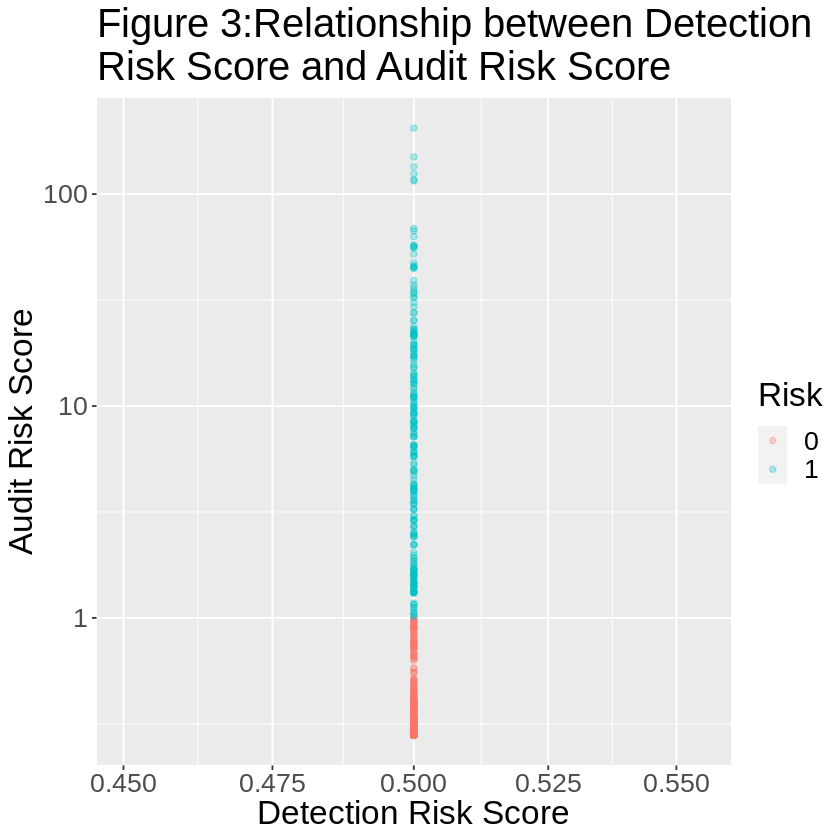

In [7]:
DR_AR_plot <- audit_training |>
    ggplot(aes(x = Detection_Risk, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Detection Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Figure 3:Relationship between Detection \nRisk Score and Audit Risk Score') +
    theme(text = element_text(size =20))
DR_AR_plot

Since the Detection Risk is constant at 0.5 throughout the dataset, it has no relationship with the Audit Risk Score.

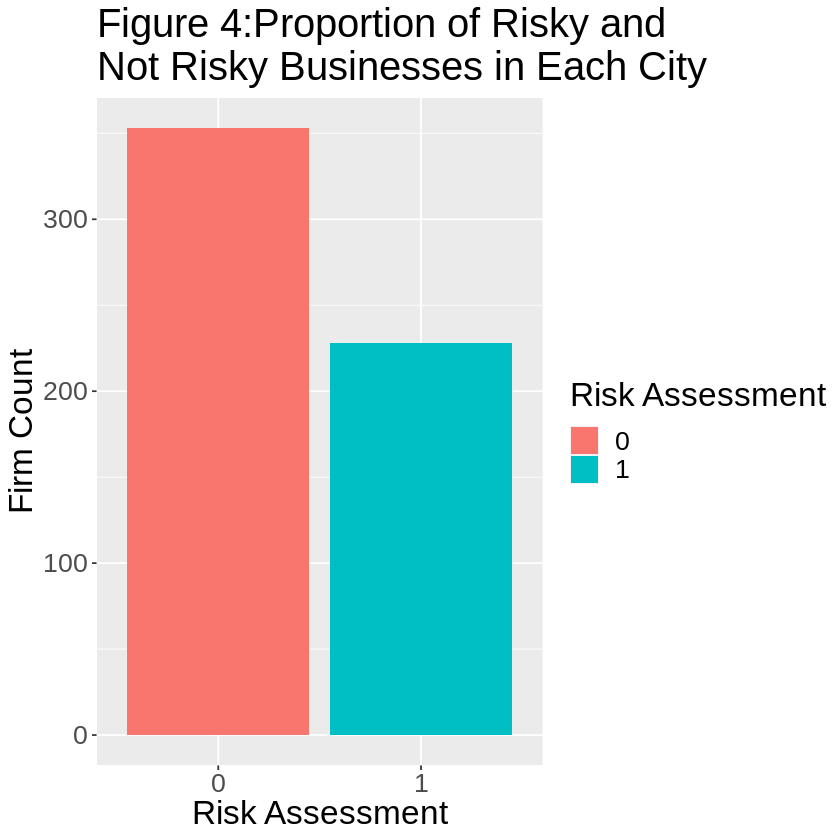

In [8]:
#Visualize Risky and Not Risky proportion in the training data set
Risk_proportion <- audit_training |>
    ggplot(aes(x = Risk, fill=Risk)) +
    geom_bar() +
    labs(x = 'Risk Assessment', y = 'Firm Count', fill = 'Risk Assessment') +
    theme(text = element_text(size = 20)) +
    ggtitle('Figure 4:Proportion of Risky and \nNot Risky Businesses in Each City')
Risk_proportion

In [9]:
#Calculate proportion percentage for each class
proportion <- tibble(Not_Risky = 353/(353+228)*100, Risky = 228/(353+228)*100)
    print('Table 3: Class proportion')
proportion

[1] "Table 3: Class proportion"


Not_Risky,Risky
<dbl>,<dbl>
60.75731,39.24269


The proportion of 'Risky' and 'Not Risky' businesses in the training dataset is approximately 40% vs 60%. This means that the majority classifier (which always guesses the majority class label from the training data, regardless of the predictor variables’ values) would always predict that a new observation as 'Not Risky' with a ~60% accuracy. These proportions show that our training set is fairly balanced. 

### Data Analysis

We will conduct our data analysis using the KNN classification model to predict the Risk classification of a business.

The predictor variables we will use are Inherent_Risk and Control_Risk as they take majority of the variables in the dataset into account. Although the Audit Risk score (ARS) includes the aforementioned risk factors as well as the Detection_Risk, the Detection Risk score has a constant value of 0.5 throughout the dataset. Hence, it will not be included in our model as it does not influence the ARS.

In [10]:
#Setting Randomization seed
set.seed(4384)

#Setting plot size
options(repr.plot.width = 6, repr.plot.height = 6)

#Set up KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#Create data frame for range of K values
kvals <- tibble(neighbors = seq(from = 1, to = 20, by =1))

#Create cross-validation folds on training data
v_fold <- vfold_cv(audit_training, v = 5, strata = Risk)

#Create predicting recipe
audit_recipe <- recipe(Risk ~ Inherent_Risk + CONTROL_RISK, data = audit_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#Collect performance statistics across given range of K values
k_finding <- workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = v_fold, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == 'accuracy')

#Show K values with the best performance
k_finding_result <- k_finding |>
    filter(mean == max(mean))
    print('Table 4: K-neighbours Estimated Accuracy')
k_finding_result

#Visualize all performances across given range of K values
k_finding_plot <- ggplot(k_finding, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = 'K neighbours', y = 'Estimated Accuracy')+
    ggtitle('Figure 5: K-neighbours \nEstimated Accuracy Plot')+
    theme(text = element_text(size = 20))

[1] "Table 4: K-neighbours Estimated Accuracy"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9948421,5,0.003426357,Preprocessor1_Model01
2,accuracy,binary,0.9948421,5,0.003426357,Preprocessor1_Model02


'set.seed' function was used to specify the randomization for model training and to ensure that the obtainable results remain unchanged every run.

To set up the specification of our K-nearest neighbour classifier model, ‘weight_func’ was set as ‘rectangular’ so that each KNN data point gets exactly one vote. In order to let R choose the best K value for us, the argument ‘tune()’ is used in the ‘neighbors’ function.

Then, we created a data frame (using ‘tibble’) with the neighbors variable using the ‘seq’ argument to specify the range of K values that R should choose from (in our case: from 1 to 10 with intervals of 1) and named this data fame ‘kvals’. 
 
After this, we used the ‘vfold_cv’ function and set v = 5 to perform a 5-fold cross-validation on the training data. We set the ‘strata’ argument to the categorical label variable (Risk) to ensure that the training and validation subsets have the right proportions for each risk assessment value (0 or 1). 

Next, we created a recipe specifying the predictor variables (‘Inherent_Risk’ and ‘CONTROL_RISK’) and target variable (‘Risk’) to preprocess and scale the data. Scaling and centering all predictors (so that mean = 0 and standard deviation = 1) ensures that our variables are on a comparable scale and allow K-NN to accurately calculate the distances between variables. 

Finally, we put the recipe and the model specification together in a workflow and used the ‘tune_grid’ function to fit the model for each K value specified in the ‘kvals’ range. We used the ‘collect_metrics’ function to aggregate the mean and standard error of our tuned K value’s validation accuracy across the data folds. We filtered these metrics for the ‘accuracy’, and filtered for the maximum value in the ‘mean’ since we know the best K is the one that gives us the highest accuracy. Given this, we discovered that the best K is 1 and 2. 

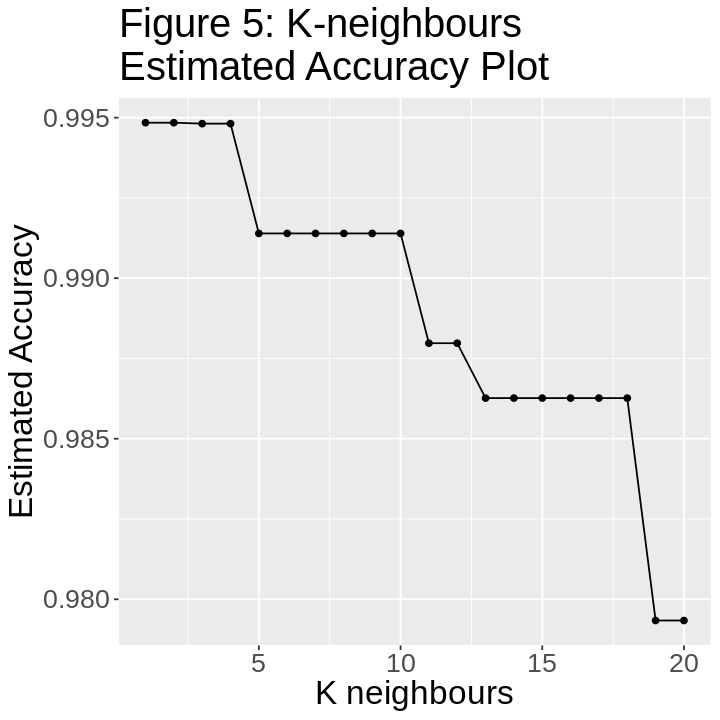

In [11]:
k_finding_plot

To visualize the accuracies of all the given range for K values, a scatter plot is created with Estimated Accuracy (mean) on the Y-axis and the KNN (neighbors) on the X-axis. The plot does indeed shows that K = 1 and K = 2 yield the highest estimated accuracy. In the graph, the estimated accuracy generally decreases as the value of K increases. 

In [12]:
#Set up KNN model using the best K value
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

#Fit the model into training data
audit_best_fit <- workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = audit_training)

#Predict class labels of testing data using the trained model
audit_predict <- predict(audit_best_fit, audit_testing) |>
    bind_cols(audit_testing) |>
    select(.pred_class, Risk)

#Show model's accuracy
audit_prediction_accuracy <- audit_predict |>
    metrics(truth = Risk , estimate = .pred_class)
    print('Table 5: Prediction Accuracy')
audit_prediction_accuracy

New names:
• `Score_B...7` -> `Score_B...8`
• `Score_B...11` -> `Score_B...12`


[1] "Table 5: Prediction Accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,1
kap,binary,1


Using pre-calculated risk scores (CONTROL_RISK and Inherent_Risk) gives us a 100% accuracy. This is because the pre-calculated variables are too correlated with the risk classification. Therefore, we will use the raw variables (PARA_A to Score) as the predictors instead to better support future obtainable data beyond the current set.  

### Recreating Model Using Raw Variables

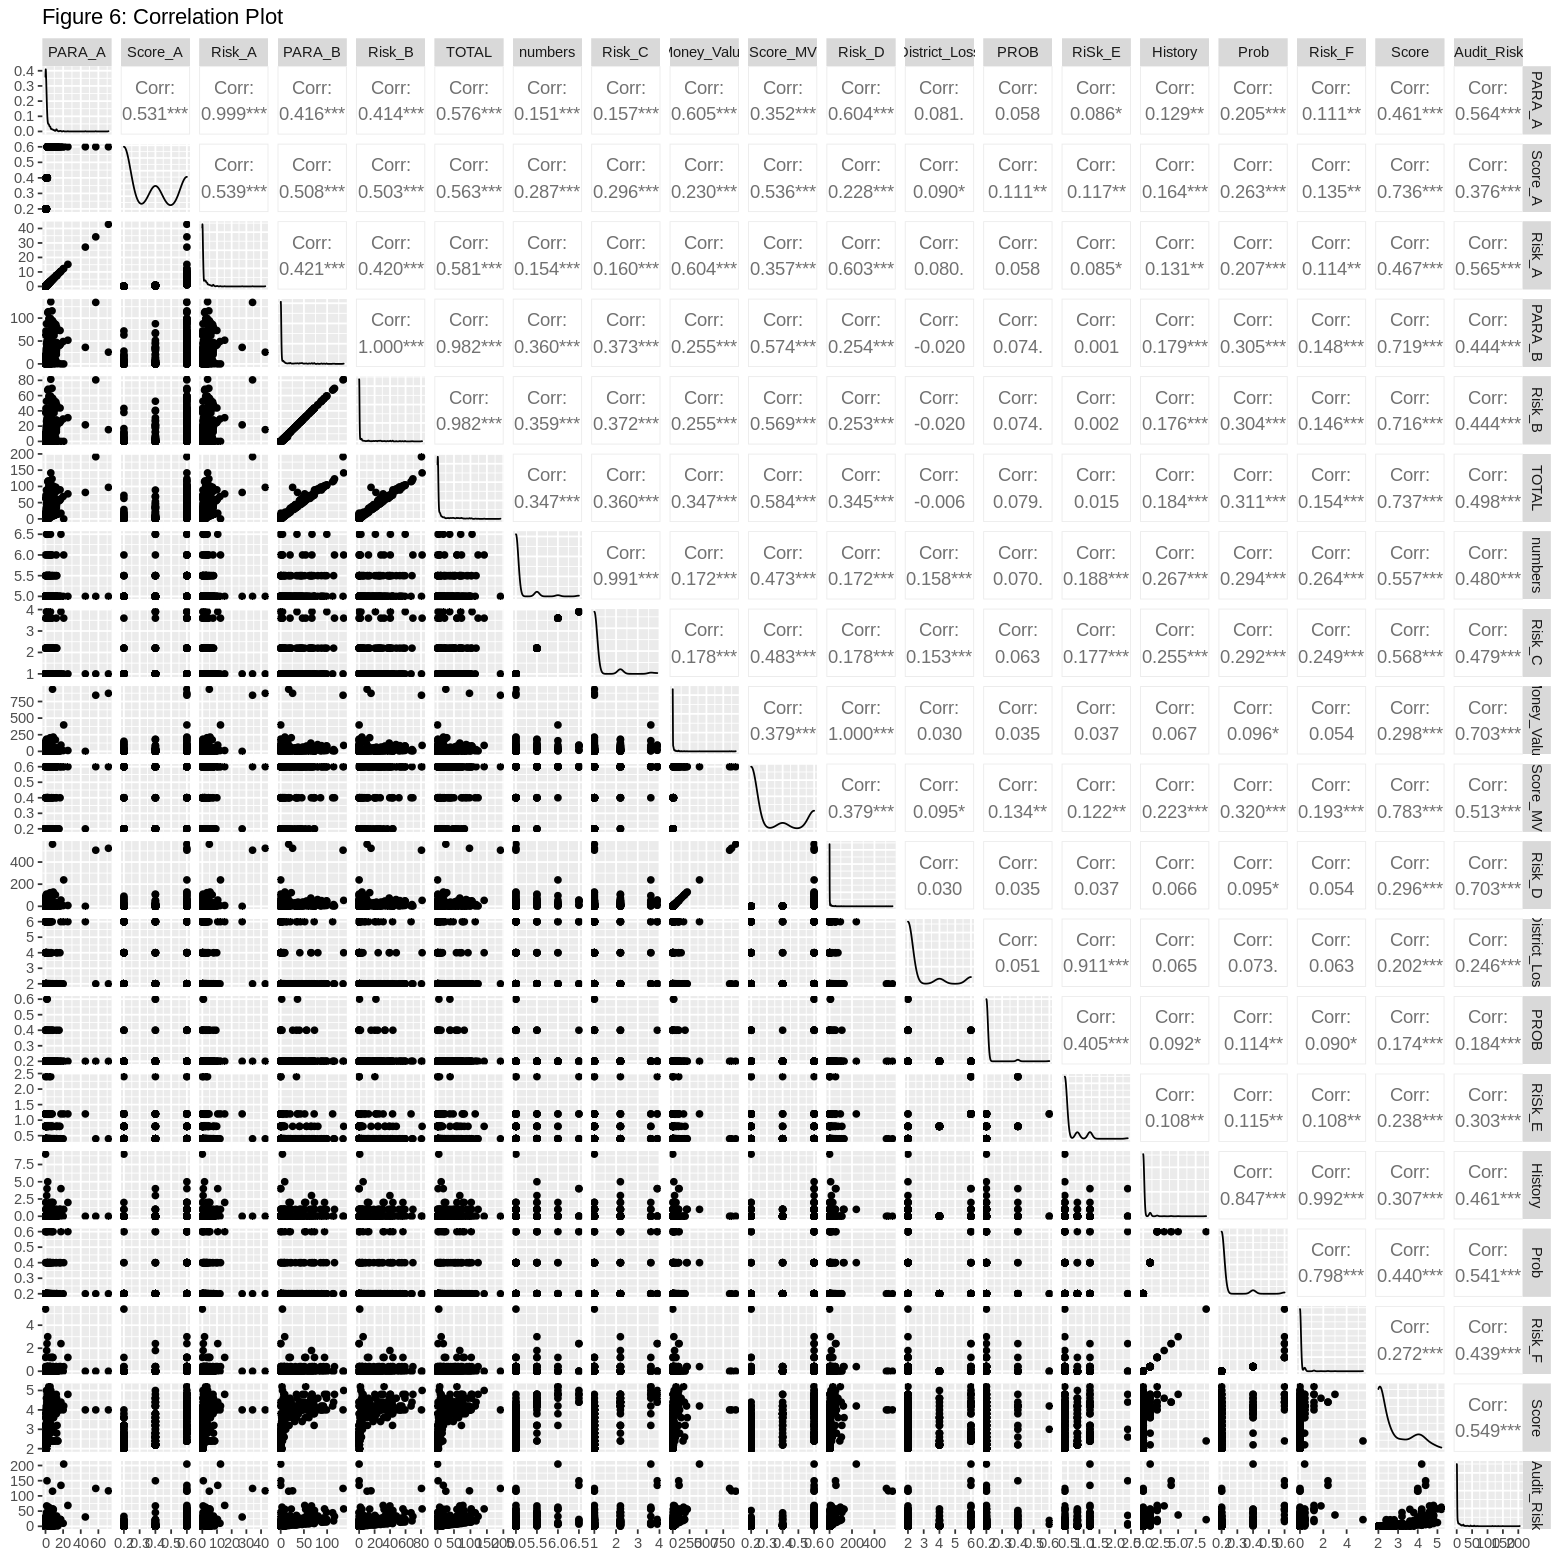

In [13]:
options(repr.plot.width = 13, repr.plot.height = 13)

#Create data frame with variables needed to test for correlation
audit_corr_data <- audit_training |>
    select(-Detection_Risk, -Inherent_Risk, -CONTROL_RISK, -LOCATION_ID, -Sector_score, -Score_B...11, -Score_B...7, -Risk)

#Produce matrix of correlation between interested variables
corr_plot <- ggpairs(audit_corr_data)+
    ggtitle('Figure 6: Correlation Plot')
corr_plot

We created a matrix of plots using ggpairs to visualize the relationships between the raw variables and the ARS. According to the matrix, the money value involved in misstatements in the past audits (Money_Value) has the highest correlation with Audit_Risk, hence we will visualize the relationship individually.

We also noticed that some pairs of explanatory variables are closely correlated, hence we will remove one variable of each pair before building our next classifier model to avoid multicollinearity problem from giving extra weight to the correlated variables more than needed.

Warning message:
“Transformation introduced infinite values in continuous x-axis”


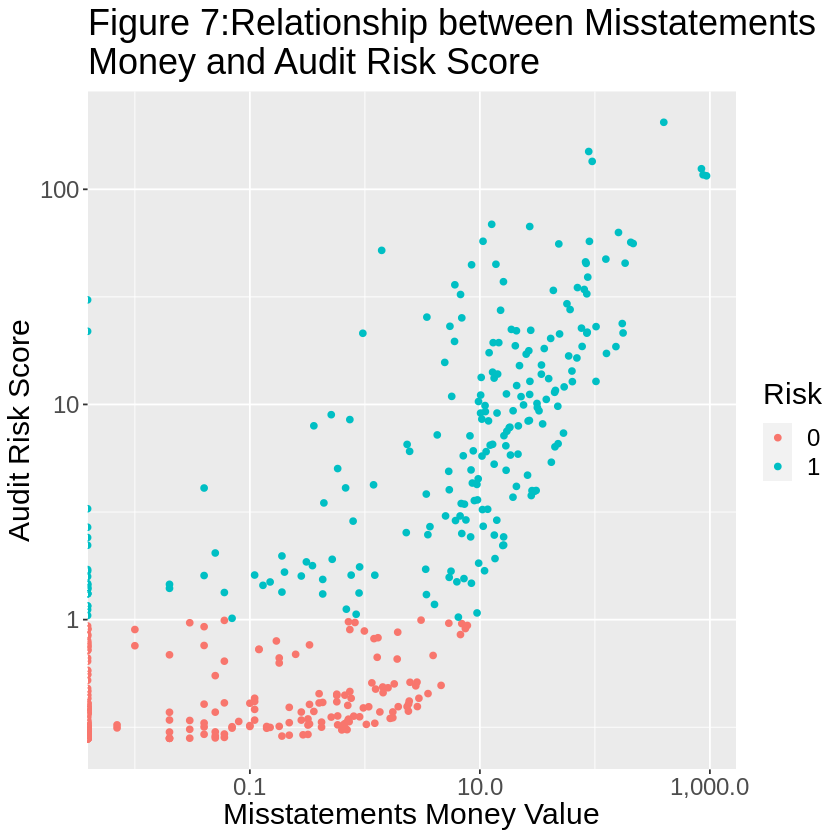

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)

#Create visualization between money value and audit risk score
Money_AR_plot <- audit_training |>
    ggplot(aes(x = Money_Value, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 1)+
    labs(x = "Misstatements Money Value", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Figure 7:Relationship between Misstatements \nMoney and Audit Risk Score') +
    theme(text = element_text(size =18))
Money_AR_plot

The relationship between the Misstatements Money and Audit Risk Score is positive as it curves upward. This is not a straight linear relationship unlike the relationship between the pre-calculated variables and Audit Risk Score.

In [15]:
set.seed(7468)

#Cleaning audit data for the raw variables of interest
audit_data_raw <- audit_data |>
    select(-Score_B...7, -Score_B...11, -Risk_A, -Risk_B, -Risk_C, -Risk_D, -RiSk_E, -Risk_F) |> 
    filter(Money_Value != "") |> 
    select(PARA_A:Score, Risk)

audit_split_raw <- initial_split(audit_data_raw, prop = 0.75, strata = Risk) 
audit_training_raw <- training(audit_split_raw)
audit_testing_raw <- testing(audit_split_raw)

#Printing training data set
audit_training_raw

PARA_A,Score_A,PARA_B,TOTAL,numbers,Money_Value,Score_MV,District_Loss,PROB,History,Prob,Score,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.2,4.83,4.83,5,0.94,0.2,2,0.2,0,0.2,2,0
0.51,0.2,0.23,0.74,5,0.00,0.2,2,0.2,0,0.2,2,0
0.00,0.2,0.83,0.83,5,2.95,0.2,2,0.2,0,0.2,2,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.06,0.4,0.63,1.69,5,0.90,0.2,6,0.2,0,0.2,2.6,1
0.00,0.2,8.49,8.49,5,0.43,0.2,2,0.2,0,0.2,3.2,1
1.06,0.4,1.60,2.66,5,16.09,0.6,2,0.2,0,0.2,3.2,1


After creating new training data set consists of only weakly correlated raw variables, we will then repeat the same steps as previously to create another KNN classifier model for this new data set.

[1] "Table 6: K-neighbours Estimated Accuracy"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9742103,5,0.007169609,Preprocessor1_Model01
2,accuracy,binary,0.9742103,5,0.007169609,Preprocessor1_Model02


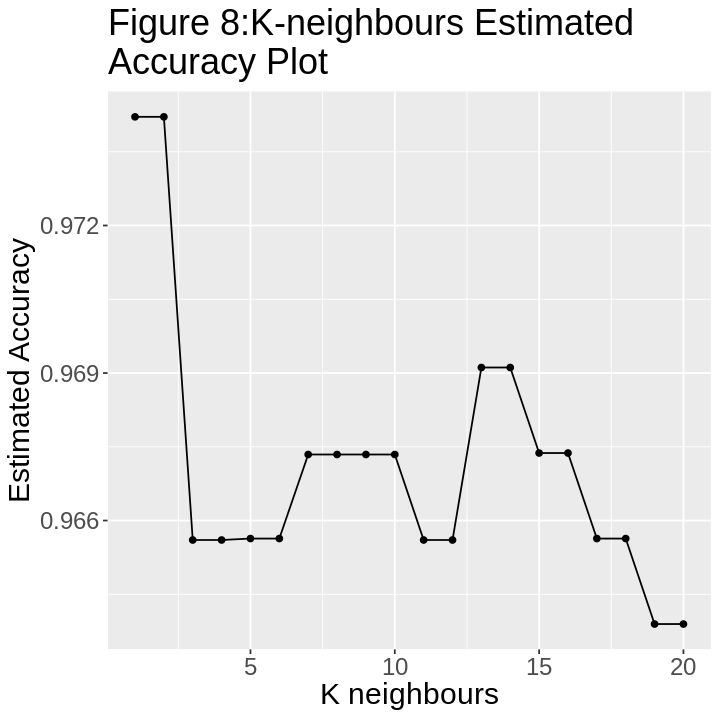

In [16]:
set.seed(2003)
options(repr.plot.width = 6, repr.plot.height = 6)

#Set up KNN model specification
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#Create data frame for range of K values
kvals_2 <- tibble(neighbors = seq(from = 1, to = 20, by =1))

#Create cross-validation folds on training data
v_fold_2 <- vfold_cv(audit_training, v = 5, strata = Risk)

#Create predicting recipe for raw variables
audit_recipe_raw <- recipe(Risk ~ . ,data = audit_training_raw) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#Collect performance statistics across given range of K values
k_finding_2 <- workflow() |>
    add_recipe(audit_recipe_raw) |>
    add_model(knn_spec_2) |>
    tune_grid(resamples = v_fold_2, grid = kvals_2) |>
    collect_metrics() |>
    filter(.metric == 'accuracy')

#Show K values with the best performance
k_finding_result_2 <- k_finding_2 |>
    filter(mean == max(mean))
    print('Table 6: K-neighbours Estimated Accuracy')
k_finding_result_2

#Visualize all performances across given range of K values
k_finding_plot_2 <- ggplot(k_finding_2, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = 'K neighbours', y = 'Estimated Accuracy')+
    ggtitle('Figure 8:K-neighbours Estimated \nAccuracy Plot')+
    theme(text = element_text(size = 18))
k_finding_plot_2

According to Table 6 and Figure 8, after tuning the model with the raw variables, the best k-value still remains as 1 and 2. Although the relationship as K value increases is still negative, the trend ofthis model differs from the previous model.

In [17]:
#Set up KNN model using the best K value
knn_spec_raw <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

#Fit the model into training data
audit_fit_raw <- workflow() |>
    add_recipe(audit_recipe_raw) |>
    add_model(knn_spec_raw) |>
    fit(data = audit_training_raw)

#Predict class labels of testing data using the trained model
audit_predict_raw <- predict(audit_fit_raw, audit_testing_raw) |>
    bind_cols(audit_testing_raw)

#Show model's accuracy
audit_prediction_accuracy_raw <- audit_predict_raw |>
    metrics(truth = Risk , estimate = .pred_class)
    print('Table 7: Prediction Accuracy')  
audit_prediction_accuracy_raw

#Identify correct and incorrect predictions
conf_mat_raw <- audit_predict_raw |>
    conf_mat(truth = Risk, estimate = .pred_class)
    print('Table 8: Confusion Matrix')
conf_mat_raw

[1] "Table 7: Prediction Accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9692308
kap,binary,0.9359045


[1] "Table 8: Confusion Matrix"


          Truth
Prediction   0   1
         0 114   2
         1   4  75

Using the interested raw variables, we get a 96.9% accuracy instead. The confusion matrix shows a total of 8 mispredictions.

## 3. Discussion

Using Control and Inherent Risk scores as our predictors gave our model an accuracy score of 100%. This was expected since these predictors were used to calculate the ARS and hence, had strong linear relationships with the ARS (Figure 1, 2, 3) that was directly used to classify the risk assessment. However, the model will not be flexible to support any freshly obtained data that will consist of only pre-calculated raw variables from new firms' financial records. Therefore, another classifier model was created using the raw variables as predictors instead; with some being excluded to avoid the multicollinearity problem to negatively affect our classification analysis. This prevented the strongly correlated variables from carrying extra weight on the distance calculation of KNN model than needed.

After using the raw variables as the predictors in our KNN classification model, the accuracy score went down to 96.9% instead. Although this is a decrease in accuracy by around 3% from the initial model, it is still a significant improvement from the 60% accuracy of the majority classifier and is more flexible than the model with pre-calculated variables. The lower estimated accuracy was well-expected since these raw variables have not gone through the calculation process, unlike control and inherent risk scores, to identify ARS and classify the risk assessment. This final model will be able to predict the risk assessment of other firms beyond the sample selection based on their financial records directly without needing to go through the calculation process in obtaining Control and Inherent Risk scores.


While these findings can help improve auditing practices for future investigations, it also raises the question of how we can ensure that the targetted businesses’ financial statements were not manipulated. Additionally, is there any way we can reduce the number of companies that commit fraud? Furthermore, what are the leading causes of companies having high Audit Risk scores in the first place?

## 4. References

### Dataset:

Hooda, Nishtha. (2018). Audit Data. UCI Machine Learning Repository. https://doi.org/10.24432/C5930Q.


### Literature:

Hooda, Nishtha, Seema Bawa, and Prashant Singh Rana. 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32.1 (2018): 48-64. 


Timbers, T., Campbell, T., & Lee, M. (2022). Data science: A first introduction. CRC Press LLC. https://doi.org/10.1201/9781003080978
